# Backtesting ML Classification-Based

In [ ]:
???

![](src/res_classification.png)

## Load the model

In [1]:
import pickle

In [2]:
with open('models/model_dt_classification.pkl', 'rb') as f:
    model_dt = pickle.load(f)

In [3]:
model_dt

DecisionTreeClassifier(max_depth=15)

## Load the data

In [4]:
import pandas as pd

df = pd.read_excel('data/Microsoft_LinkedIn_Processed.xlsx', index_col=0, parse_dates=['Date'])
df

,Open,High,Low,Close,Adj Close,Volume,change_tomorrow,change_tomorrow_direction
Date,,,,,,,,
2016-12-08,61.299999,61.580002,60.840000,61.009998,55.705235,21220800,1.549141,UP
2016-12-09,61.180000,61.990002,61.130001,61.970001,56.581772,27349400,0.321694,UP
2016-12-12,61.820000,62.299999,61.720001,62.169998,56.764374,20198100,1.286125,UP
2016-12-13,62.500000,63.419998,62.240002,62.980000,57.503944,35718900,-0.478620,DOWN
2016-12-14,63.000000,63.450001,62.529999,62.680000,57.230022,30352700,-0.159793,DOWN
...,...,...,...,...,...,...,...,...
2023-12-18,369.450012,373.000000,368.679993,372.649994,372.649994,21802900,0.163429,UP
2023-12-19,371.489990,373.260010,369.839996,373.260010,373.260010,20603700,-0.712324,DOWN
2023-12-20,375.000000,376.029999,370.529999,370.619995,370.619995,26316700,0.781714,UP


## Backtesting.py Library

### Create your Strategy Class

In [5]:
from backtesting import Backtest, Strategy

In [ ]:
Backtest(???)

In [6]:
df_explanatory = df.drop(columns=['change_tomorrow', 'change_tomorrow_direction'])

In [7]:
model_dt.predict(X=df_explanatory)

array(['UP', 'UP', 'UP', ..., 'UP', 'UP', 'UP'], dtype=object)

#### Simulate the prediction for the last observation

In [10]:
explanatory_today = df_explanatory.iloc[[-1],:]

In [13]:
forecast_tomorrow = model_dt.predict(explanatory_today)[0]

#### Write the prediction process in the Strategy class

In [ ]:
class ClassificationUP(Strategy):
    def init(self):
        self.model = model_dt

    def next(self):
        explanatory_today = df_explanatory.iloc[[-1],:]
        forecast_tomorrow = model_dt.predict(explanatory_today)[0]
        
        # conditions to sell or buy

#### Calculate Purchase Recommendation

##### Buy if it goes up

In [17]:
list_buy_sell = []

In [18]:
for tomorrow_direction in df.change_tomorrow_direction:
  if tomorrow_direction =='UP':
    list_buy_sell.append(1)

  elif tomorrow_direction =='DOWN':
    list_buy_sell.append(-1)

In [19]:
df['buy_sell'] = list_buy_sell

In [21]:
df[['change_tomorrow_direction', 'buy_sell']].head(10)

,change_tomorrow_direction,buy_sell
Date,,
2016-12-08,UP,1
2016-12-09,UP,1
2016-12-12,UP,1
2016-12-13,DOWN,-1
2016-12-14,DOWN,-1
2016-12-15,DOWN,-1
2016-12-16,UP,1
2016-12-19,DOWN,-1
2016-12-20,DOWN,-1


##### Buy if it goes and sell if down

> You can only sell if you have already bought

In [22]:
list_buy_sell = []
already_bought = False

In [23]:
for tomorrow_direction in df.change_tomorrow_direction:
  if tomorrow_direction =='UP' and already_bought==False:
    list_buy_sell.append(1)
    already_bought = True

  elif tomorrow_direction =='DOWN' and already_bought:
    list_buy_sell.append(-1)
    already_bought = False

  else:
    list_buy_sell.append(0)

In [24]:
df['buy_sell_track'] = list_buy_sell

In [25]:
df[['change_tomorrow_direction', 'buy_sell', 'buy_sell_track']].head(10)

,change_tomorrow_direction,buy_sell,buy_sell_track
Date,,,
2016-12-08,UP,1,1
2016-12-09,UP,1,0
2016-12-12,UP,1,0
2016-12-13,DOWN,-1,-1
2016-12-14,DOWN,-1,0
2016-12-15,DOWN,-1,0
2016-12-16,UP,1,1
2016-12-19,DOWN,-1,-1
2016-12-20,DOWN,-1,0


#### Add conditions to the strategy

In [26]:
class ClassificationUP(Strategy):
    def init(self):
        self.model = model_dt
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[[-1],:]
        forecast_tomorrow = model_dt.predict(explanatory_today)[0]
        
        # conditions to sell or buy
        if forecast_tomorrow =='UP' and self.already_bought==False:
            self.buy()
            self.already_bought = True

        elif forecast_tomorrow =='DOWN' and self.already_bought:
            self.sell()
            self.already_bought = False

        else:
            pass

### Define initial conditions

In [27]:
bt = Backtest(data = df_explanatory, strategy=ClassificationUP,
              cash=10000, commission=.002, exclusive_orders=True)

### Run backtesting

In [29]:
results = bt.run()

### Interpret backtesting results

In [30]:
results.to_frame(name='Values').loc[:'Return [%]']

,Values
Start,2016-12-08 00:00:00
End,2023-12-22 00:00:00
Duration,2570 days 00:00:00
Exposure Time [%],99.887133
Equity Final [$],60189.55283
Equity Peak [$],61641.775975
Return [%],501.895528


<Axes: xlabel='Date'>

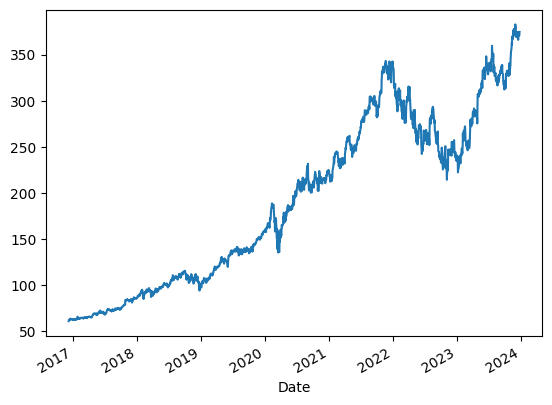

In [31]:
df.Close.plot()

## Practice to master the knowledge

Work on the challenge with another dataset:

1. Learn the <a>mental models</a> to solve the challenge faster.
2. Complete the <a href="03C_Backtesting ML Classification-Based.ipynb">notebook</a>.